# W207 Summer 2017 Final Project

## Personalized Medicine: Redefining Cancer Treatment



#### Matt Shaffer https://github.com/planetceres 
#### Kaggle Competition: https://www.kaggle.com/c/msk-redefining-cancer-treatment

According to [discussion boards](https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35810#202604) on Kaggle, the classes we are trying to predict appear to be as follows:

1. Likely Loss-of-function
2. Likely Gain-of-function
3. Neutral
4. Loss-of-function
5. Likely Neutral
6. Inconclusive
7. Gain-of-function
8. Likely Switch-of-function
9. Switch-of-function


#### Dependencies

In [1]:
import os
import time
import glob
import re
import pandas as pd
import numpy as np
import scipy.sparse as sps
import Bio

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import explained_variance_score
from sklearn.pipeline import make_pipeline

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
from itertools import islice

In [3]:
data_directory = '/Users/Reynard/dropbox/Data/kaggle/Personalized Medicine'
model_directory = data_directory + '/saved_models'

In [5]:
model_path = os.path.join(model_directory, model_name)

In [6]:
# Create model directory if it does not exist
if not os.path.isdir(model_directory):
    print("creating directory for saved models")
    os.mkdir(model_directory)

In [10]:
def print_op_str(data_type):
    p = "Done processing " + data_type + " data in {:.2f} seconds"
    return p

In [11]:
def print_blank(n):
    print(" "*n, end="\r")

### Data Overview

In [4]:
train_variants = pd.read_csv(data_directory + "/input/training_variants")
test_variants = pd.read_csv(data_directory + "/input/test_variants")
train_text = pd.read_csv(data_directory + "/input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv(data_directory + "/input/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

The test set has no labels and is used only for score submission. This will be a challenge since the sample size is small, and it will be hard to learn the properties of the population needed to perform inference. 

In [5]:
# Test set has no labels and is used 
print(list(train_variants.columns))
print(list(test_variants.columns))

['ID', 'Gene', 'Variation', 'Class']
['ID', 'Gene', 'Variation']


In addition to the gene variant data, we also have a text corpus for each example that provides the clinical evidence that human experts used to classify the genetic mutations. This is essentially an unstructured feature set, and our first task will be to map this noisy data to a set of features that can more easily be used for prediction. 

In [6]:
print(list(train_text.columns))
print(list(test_text.columns))

['ID', 'Text']
['ID', 'Text']


In [7]:
# Merge the text with the variant data, and separate the target values (`Class`) from the features
train = pd.merge(train_variants, train_text, how='left', on='ID')
y_train = train['Class'].values
X_train = train.drop('Class', axis=1)

In [8]:
# Do the same thing with the test data, but note that there are no classes to separate as targets
X_test = pd.merge(test_variants, test_text, how='left', on='ID')
test_index = X_test['ID'].values

In [9]:
# Create mini data sets for model building
train_mini = train.sample(frac=0.05)
y_train_mini = train_mini['Class'].values
X_train_mini = train_mini.drop('Class', axis=1)
X_test_mini = X_test.sample(frac=0.05)
test_index_mini = X_test_mini['ID'].values

# Create mini dev set for model building
dev_mini = train.sample(frac=0.05)
y_dev_mini = dev_mini['Class'].values
X_dev_mini = dev_mini.drop('Class', axis=1)

In [10]:
X_train_mini.shape

(166, 4)

In [12]:
# create dataset with all variants
all_variants = pd.concat([train_variants, test_variants], ignore_index=True)

### EDA

In [19]:
train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [20]:
train.tail()

,ID,Gene,Variation,Class,Text
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...
3320,3320,RUNX1,K83E,4,The most frequent mutations associated with le...


Looking at the gene variants to get an idea of nomenclature:

In [228]:
for v in train_variants['Variation'].unique():
    print('{}'.format(v), end='\t')
for v in test_variants['Variation'].unique():
    print('{}'.format(v), end='\t')

Truncating Mutations	W802*	Q249E	N454D	L399V	V391I	V430M	Deletion	Y371H	C384R	P395A	K382E	R420Q	C381A	P428L	D390Y	Q367P	M374V	Y371S	H94Y	C396R	G375P	S376F	P417A	H398Y	S2G	Y846C	C228T	H412Y	H876Q	Promoter Mutations	P704S	Amplification	C250T	G1809R	G1809K	D1709E	D1709A	E1705A	D1810A	E1705K	T1365M	V648G	T844M	A707T	Promoter Hypermethylation	R1343L	A209T	Y280H	D927G	N510K	F248S	L708P	V995M	Y412F	F74S	R1040L	R453C	R1209W	A1022E	Q984K	T605M	K218T	N1125I	Y35C	Y35N	Y35H	L234fs	L1273F	P284L	Q276*	T286A	T283A	I290A	I290R	A77S	A77P	A77T	M90I	Overexpression	N45S	R487Q	C41Y	G52R	P83L	S241L	S387Y	TGFBR1*6A	R537P	D404G	P525L	R922*	R976H	E1322*	T1219I	G39E	R1076C	R1095H	V509A	E946*	F1088Lfs*5	F1088Sfs*2	N1333Gfs*	K700R	R625C	E622D	H662Q	R625D	K666M	H662R	R625H	K666T	R625L	E622Q	R625G	K666N	K666R	K700E	R957Q	L747_T751delinsP	S752_I759del	I491M	D770_P772dup	G719A	G735S	N771_H773dup	K467T	E746_T751insIP	D770_N771insD	G724S	K745_A750del	EGFRvIII	V765A	EGFRvII	L858M	H870R	E758G	H773L	T710A	L747P	E709V	D761

L1204F	G1269S	G1269A	L1196Q	A1099T	G1286R	R1060H	D1270G	E1210K	N1178H	K1062M	R1192P	R1231Q	V597A	D1349H	R1464*	I1183T	L1198P	C1156Y	L1152P	H694R	I1170N	R1275L	I1170S	A1234T	S100F	G325R	R133*	S505N	W515K	W515L	P106L	Q233*	S217C	S217T	S217A	T24A	P86H	D121G	R64P	Y98H	S68W	V84L	L128F	V155A	G114R	H115R	L118P	R200W	Y98N	Q164R	A149P	L188Q	R69C	Y112H	I151S	L158P	N78S	F119S	S65W	Q145H	L158Q	H191D	L188V	L118R	W117C	L63P	E70K	P25L	R167W	R82P	S65L	L158V	S65A	Q96P	R167Q	V321M	R154W	R228K	P326L	N234I	R134Q	G85R	R304*	Q72L	FLT3 internal tandem duplications	D835N	N676K	Y599_D600insGLYVDFREYEY	D835A	F590G	T167A	D324N	Y591D	F594L	V557I	I867S	D835del	I836del	Y599_D600insSTDNEYFYVDFREYEY	E598_Y599insDVDFREYE	W603_E604insDREYEYDLKW	N676D	S840_N841insGS	A627T	G831E	R834Q	N676S	M664I	F691L	M737I	V194M	V592A	S451F	S451E	D835H	Y842C	D835E	Y364H	L601_K602insREYEYDL	F594_R595insSDNEYFYVDF	L611_E612insCSSDNEYFYVDFREYEYDLKWEFPRENL	E612_F613insGYVDFREYEYDLKWEFRPRENLEF	V579A	Y599_D600insPAPQIMSTSTLISENMNIA	N841I	Y57

R134W	F1403C	R243W	V359M	S342N	L65P	C73R	R268C	T6211M	R167L	N463D	R738C	G458V	L451V	K185T	I84S	V617F	W679C	R465C	Y1794C	I109N	C515R	R194H	G255E	S135T	I1929V	G143E	H289Q	P258L	L307P	A56V	D302H	V32M	S186P	L57Q	C77R	G48V	R392G	R617C	I62V	K554N	W87G	R447C	D619G	T182P	S221R	S180N	D2045N	V317M	N107I	D268N	R133W	Deletion	A210P	Q408P	N141S	R725W	P375L	P616R	V310E	R583Q	R372W	R739H	T1220I	I1010T	H136R	Q270R	H20P	W453R	C104R	G233D	D482N	P315S	Y795C	R499H	S200Y	R353C	P406L	R146Q	S1481N	R4674G	R605P	E319K	G262D	G477R	R515S	G364V	T294K	R192Q	R621*	T366P	T32R	G79R	L73F	A318T	N1270S	G89D	S111P	D159N	G1306E	R366C	G353S	A178P	N232S	M424T	N345K	D134G	F451L	R529Q	A395D	M165R	A219D	N1860S	L175Q	Q521E	L1971R	R345C	G348E	D1099Y	S247W	S218F	W240R	A932V	L381P	R767W	G50E	G169E	G365W	P383L	C29R	P2172Q	D191N	A2G	H96D	K77Q	C289S	G549D	D1594H	P208S	R316Q	I12T	S39F	R6C	P77T	C133W	N2829R	E197D	P31L	Q67R	R50Q	N161K	P274L	S692T	K106I	C217R	H323R	G1771D	P299L	T1464I	R399Q	A775_G776insYVMA	W255G	E262K	Q590H	A391V	N355S	

	G551D	M126K	N148S	A60R	L584P	A1853V	H303N	G243D	G101R	R272Q	P1873R	G71R	S657G	P511R	L33P	R816W	E297G	R119G	V145A	V790M	W276S	R339Q	Y53C	S606L	C40G	T359K	P229Q	R265W	Q2265R	P88R	C108F	T1313M	T738M	A33P	A43T	C66W	R211W	S146N	S3018F	I427M	T1036M	W239C	H204D	V11G	D974V	P194H	G1052C	G294R	S72P	P235S	C268W	G357E	E125G	V822M	R50P	R2110W	P2319S	D35Y	T78M	T528M	Q448E	W757C	A334V	R583H	Q207E	T512I	S45G	C315R	T380M	A211T	S435F	S140G	C104F	V281I	S257L	L45P	A553T	L37S	C56R	D648V	H165D	T425M	Y2163C	M384I	V559_G565del	H232N	E486K	R135G	A4074P	E326K	A198V	R423H	R399W	N29I	G418V	N144H	V76M	Q210R	L418R	P1780A	R761H	R111P	R236C	S49C	L2027F	M286T	G228W	R271K	D255N	Q182H	R798*	R634Q	C3198R	S406L	A169T	F508C	A919P	R608Q	G56R	P470S	G222E	G393E	D417N	G201E	L304R	Y1584C	P574H	T91A	N409S	G537R	F788L	G108D	D761N	G315S	N174S	P121L	R973Q	L130P	R280H	M26I	S827G	C491W	D1865N	L285F	G90S	P2301T	C160Y	L151F	I1718T	M1476I	K319E	V9M	null330W	R2108H	T1151R	Y120C	T168I	P87S	G309D	Y316C	V530I	G992W	G420E	V53M	C261F	N161S	I

Some variants include the same name as their gene rather than HGVS amino acid translations.

In [491]:
train_variants[train_variants['Variation'].str.contains('EGFR') == True]

,ID,Gene,Variation,Class
150,150,EGFR,EGFRvIII,7
152,152,EGFR,EGFRvII,7
164,164,EGFR,EGFR-RAD51 Fusion,7
170,170,EGFR,EGFRvV,7
211,211,EGFR,EGFR-KDD,7
238,238,EGFR,EGFRvIV,7
268,268,EGFR,EGFR-PURB Fusion,2


In [90]:
train_variants[train_variants['Variation'].str.contains('fs') == True]

,ID,Gene,Variation,Class
72,72,RAD50,L234fs,1
113,113,MSH6,F1088Lfs*5,4
114,114,MSH6,F1088Sfs*2,4
120,120,PBRM1,N1333Gfs*,4
808,808,ERCC2,S746fs,1
819,819,ERCC2,F568fs,1
959,959,KDM5C,V1075Yfs*2,4
1074,1074,FOXA1,S453fs*,2
1093,1093,MAP3K1,T1481fs,1
1096,1096,MAP3K1,T779fs,1


In [94]:
test_variants[test_variants['Variation'].str.contains('fs') == True]

,ID,Gene,Variation
2985,2985,AGO2,A603fs
4984,4984,RUNX1,S291fsX300


In [93]:
train_variants[train_variants['Variation'].str.contains('trunc') == True]

,ID,Gene,Variation,Class
1707,1707,PPM1D,422_605trunc,7
2123,2123,CCND1,256_286trunc,7
3096,3096,NOTCH2,1_2009trunc,1
3097,3097,NOTCH2,2010_2471trunc,2


#### Mistakes in data
Most variants conform to the HGVS nomenclature where mutations such as `del`, `ins`, `trunc`, etc are in lower case, while capital letters are reserved for aminos like `T`, `A`, `R` and so forth. This data set contains mistakes though, as we can see from the following, where `del` has been capitalized. The official notation should be `M1_E165del` rather than `M1_E165DEL` as we see here:

In [101]:
train_variants[train_variants['Variation'].str.contains('M1_E165DEL') == True]

,ID,Gene,Variation,Class
961,961,KDM5C,M1_E165DEL,4


Since much of the test data is fabricated, I suspect that all entries containing a 'null' string in the `Variation` column are planted by the competition organizers since none of these examples show up in the training set. 

In [100]:
# Get variants with `null` in the text
# these are likely to be generated samples since they only appear in the test set
all_variants[all_variants['Variation'].str.contains('null') == True]

,Class,Gene,ID,Variation
3716,NaN,RUNX2,395,null522S
3967,NaN,PAX6,646,null423L
4017,NaN,SHOX,696,null293R
4540,NaN,ITM2B,1219,null267R
4749,NaN,SH2D1A,1428,null129R
4787,NaN,FKRP,1466,null496R
4859,NaN,PNPO,1538,null262Q
5428,NaN,HSD3B2,2107,null373C
5644,NaN,SELENON,2323,null462G
5688,NaN,KISS1R,2367,null399R


### Checking for similarity between `Gene` and `Variant` text

To see if there are other interesting correlations between gene names and variants in the data, we can look at the Levenstein distance betwen text strings.

In [521]:
from difflib import SequenceMatcher

def text_similarity(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

Here is a baseline test using the `EGFR` gene and it's variants.

In [531]:
text_d = []
for i, v in enumerate(train_variants['Variation'].unique()):
    sim = text_similarity('EGFR', train_variants['Variation'][i])
    text_d.append(('EGFR', train_variants['Variation'][i], sim))

pd.DataFrame(text_d).sort_values(2, ascending=False)[0:10]

,0,1,2
170,EGFR,EGFRvV,0.800000
238,EGFR,EGFRvIV,0.727273
152,EGFR,EGFRvII,0.727273
211,EGFR,EGFR-KDD,0.666667
150,EGFR,EGFRvIII,0.666667
2928,EGFR,G31R,0.500000
1071,EGFR,G87R,0.500000
645,EGFR,G67R,0.500000
1056,EGFR,E75G,0.500000
2915,EGFR,G81R,0.500000


Looking at all gene-variant pairings, we see a few interesting cases where the variation is simply the gene with a few extra characters. This will require some domain research to understand what they mean.

In [535]:
text_d = []
train_variants_unique = train_variants['Variation'].unique()
train_genes_unique = train_variants['Gene'].unique()
for i, v in enumerate(train_variants_unique):
    for j, g in enumerate(train_genes_unique):
        sim = text_similarity(g, v)
        text_d.append({'Gene':g, 'Variation':v, 'Similarity': sim})

pd.DataFrame(text_d).sort_values('Similarity', ascending=False)[0:100]

,Gene,Similarity,Variation
751844,DNMT3B,0.923077,DNMT3B7
775101,CASP8,0.909091,CASP8L
39886,EGFR,0.800000,EGFRvV
22982,TGFBR1,0.800000,TGFBR1*6A
751843,DNMT3A,0.769231,DNMT3B7
157254,IL7R,0.750000,L97R
459070,RAD51C,0.727273,R514C
229654,RAD51C,0.727273,R561C
654142,BRAF,0.727273,p61BRAF
35134,EGFR,0.727273,EGFRvII


### Checking for special characters and non-coded variations

Variants labeled with the word `Fusion` are fairly common, and may provide information about certain classes.

In [13]:
train_variants[train_variants['Variation'].str.contains('Fusion') == True]

,ID,Gene,Variation,Class
164,164,EGFR,EGFR-RAD51 Fusion,7
268,268,EGFR,EGFR-PURB Fusion,2
279,279,NKX2-1,IGH-NKX2 Fusion,2
280,280,NKX2-1,TRB-NKX2-1 Fusion,2
282,282,NKX2-1,Fusions,2
283,283,NKX2-1,TRA-NKX2-1 Fusion,2
289,289,BRD4,BRD4-NUT Fusion,7
300,300,TMPRSS2,TMPRSS2-ETV1 Fusion,7
301,301,TMPRSS2,TMPRSS2-ETV5 Fusion,2
302,302,TMPRSS2,TMPRSS2-ETV4 Fusion,2


Only a few characters contain dashes (and not the word `Fusion`)

In [508]:
train_variants[(train_variants['Variation'].str.contains('-') == True) & (train_variants['Variation'].str.contains('Fusion') == False)]

,ID,Gene,Variation,Class
211,211,EGFR,EGFR-KDD,7
1801,1801,AR,AR-V7,7
2054,2054,MYC,MYC-nick,6


Checking for underscores. Underscores are generally a separator between two proteins.

In [517]:
train_variants[train_variants['Variation'].str.contains('_') == True]

,ID,Gene,Variation,Class
138,138,EGFR,L747_T751delinsP,7
139,139,EGFR,S752_I759del,2
141,141,EGFR,D770_P772dup,7
144,144,EGFR,N771_H773dup,7
146,146,EGFR,E746_T751insIP,7
147,147,EGFR,D770_N771insD,7
149,149,EGFR,K745_A750del,7
165,165,EGFR,D770_N771insNPG,7
166,166,EGFR,E746_A750del,7
171,171,EGFR,A859_L883delinsV,2


In [513]:
test_variants[(test_variants['Variation'].str.contains('_') == True) & (test_variants['Variation'].str.contains('Fusion') == False)]

,ID,Gene,Variation
119,119,KIT,P551_M552del
344,344,PDGFRA,W559_R560del
930,930,ERBB2,A775_G776insYVMA
961,961,PDGFRA,D842_I843delinsIM
1901,1901,PIK3CA,P447_L455del
2151,2151,EGFR,L747_S752del
2230,2230,FLT3,D600_L601insDFREYEYD
2261,2261,BRAF,V600_K601delinsE
2281,2281,EGFR,V769_D770insASV
2648,2648,KIT,Y568_L576delinsVN


The different actions a gene can take should be important in predicting the class. For example, according to a domain expert I spoke with, "a frameshift mutation is likelier to result in a loss of function (because it scrambles everything downstream of said mutation) particularly if it occurs early in the protein". It seems like we should care about these things when considering the name of a variant.

In [26]:
v_actions = []
v_train_us = train_variants[train_variants['Variation'].str.contains('_') == True]
for gene in v_train_us['Variation']:
    v_action = ''.join([c for c in gene if c.islower()])
    v_actions.append(v_action)
    #print(''.join([c for c in gene if c.islower()]))
v_test_us = test_variants[test_variants['Variation'].str.contains('_') == True]
for gene in v_test_us['Variation']:
    v_action = ''.join([c for c in gene if c.islower()])
    v_actions.append(v_action)
    #print(''.join([c for c in gene if c.islower()]))

set(v_actions)

{'', 'del', 'delins', 'dup', 'ins', 'splice', 'trunc'}

Text entries that have no digits seem to have categorical descriptions rather than protein expressions. This makes it difficult to break them down further, but maybe they have predictive power collectively.

In [88]:
text_entries = []
for v in train_variants['Variation'].unique():  
    text_entries.append(v) if (any(str.isdigit(c) for c in v) == False) else None
print(len(set(text_entries)))
    #print('{}'.format(v), end='\t') if (any(str.isdigit(c) for c in v) == False) else None
for v in test_variants['Variation'].unique():  
    text_entries.append(v) if (any(str.isdigit(c) for c in v) == False) else None
print(len(text_entries))
text_entries = set(text_entries)
print(text_entries)

37
42
{'EGFRvV', 'Hypermethylation', 'TRKAIII Splice Variant', 'IGL-MYC Fusion', 'NIN-PDGFRB Fusion', 'Promoter Mutations', 'STRN-PDGFRA Fusion', 'AGK-BRAF Fusion', 'Fusions', 'Deletion', 'KDR-PDGFRA Fusion', 'Copy Number Loss', 'CAD-ALK Fusion', 'DNA binding domain deletions', 'Wildtype', 'DNA binding domain insertions', 'Epigenetic Silencing', 'FUS-ERG Fusion', 'MYC-nick', 'BCOR-RARA Fusion', 'EGFRvIII', 'Overexpression', 'Truncating Mutations Upstream of Transactivation Domain', 'Amplification', 'EGFR-PURB Fusion', 'BCR-PDGFRA Fusion', 'Truncating Mutations in the PEST Domain', 'IGK-MYC Fusion', 'Single Nucleotide Polymorphism', 'IGH-MYC Fusion', 'STRN-ALK Fusion', 'NPM-ALK Fusion', 'Truncating Mutations', 'Promoter Hypermethylation', 'DNA binding domain missense mutations', 'EGFR-KDD', 'EGFRvII', 'EGFRvIV'}


In [89]:
type_tokens = []
for i in text_entries:
    type_tokens.append(i) if 'Fusion' not in i else None
    #print(i) if 'Fusion' not in i else None
pd.DataFrame(type_tokens)

,0
0,EGFRvV
1,Hypermethylation
2,TRKAIII Splice Variant
3,Promoter Mutations
4,Deletion
5,Copy Number Loss
6,DNA binding domain deletions
7,Wildtype
8,DNA binding domain insertions
9,Epigenetic Silencing


Most other entries fit the HGVS format of amino-position-amino

In [86]:
no_type_token = []
for var in train_variants['Variation']:
    if not any(x in var for x in type_tokens):
        no_type_token.append({'type':var})
pd.DataFrame(pd.DataFrame(no_type_token).type.unique())

,0
0,W802*
1,Q249E
2,N454D
3,L399V
4,V391I
5,V430M
6,Y371H
7,C384R
8,P395A
9,K382E


## Relationship between `Text` field and `Variation`

A gene can have many variations and the same text in this dataset. This will make it difficult for the model to discren between classes without understanding more about the variants themselves.

In [288]:
train[train['Gene'] == 'KDM5C']

,ID,Gene,Variation,Class,Text
957,957,KDM5C,D402Y,4,Abstract Mutations in KDM5C are an important ...
958,958,KDM5C,P480L,4,Abstract Mutations in KDM5C are an important ...
959,959,KDM5C,V1075Yfs*2,4,Abstract Mutations in KDM5C are an important ...
960,960,KDM5C,Overexpression,2,"Currently, few prognostic factors are availabl..."
961,961,KDM5C,M1_E165DEL,4,Abstract Mutations in KDM5C are an important ...


Text example:

In [300]:
print(train[(train['Gene'] == 'KDM5C') & (train['Variation'] == 'Overexpression')]['Text'].__dict__)
for i in train[(train['Gene'] == 'KDM5C') & (train['Variation'] == 'Overexpression')]['Text']:
    print(i)

{'_cacher': ('Text', <weakref at 0x1484e11d8; dead>), '_data': SingleBlockManager
Items: Int64Index([960], dtype='int64')
ObjectBlock: 1 dtype: object, '_subtyp': 'series', '_index': Int64Index([960], dtype='int64'), 'is_copy': <weakref at 0x1233167c8; to 'DataFrame' at 0x122f6d1d0>, '_item_cache': {}, '_name': 'Text'}
Currently, few prognostic factors are available to predict the emergence of castration-resistant prostate cancer and no curative options are available. Epigenetic gene regulation has been shown to trigger prostate cancer metastasis and androgen independence. Histone lysine demethylases (KDMs) are epigenetic enzymes that can remove both repressive and activating histone marks. KDM5 family members are capable of removing the histone H3 lysine 4 dimethylation–activating mark, rendering them potential players in the down-regulation of tumor suppressors and suggesting that their activity could repress oncogenes. Here, we systematically investigated KDM5C expression patterns i

### Class balance of examples with no numbers

Coming back to the example earlier about variants that are text classes, rather than protein expressions that might contain more information, if we look at only the class labels for those classifiers, we see they mostly correspond to classes 1 and 2.

In [245]:
text_classes = []
for i, v in enumerate(train_variants['Variation']):  
    text_classes.append(train_variants['Class'][i]) if (any(str.isdigit(c) for c in v) == False) else None
print(text_classes)


[1, 1, 1, 7, 2, 1, 1, 4, 1, 2, 1, 2, 7, 7, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 7, 7, 7, 7, 7, 7, 2, 7, 2, 1, 1, 7, 1, 7, 2, 1, 2, 2, 1, 1, 1, 2, 1, 4, 1, 4, 4, 1, 1, 4, 1, 1, 4, 7, 2, 7, 1, 4, 7, 1, 1, 4, 1, 1, 4, 1, 4, 4, 1, 1, 7, 7, 2, 2, 1, 1, 1, 1, 1, 2, 1, 7, 2, 1, 1, 7, 7, 7, 7, 2, 2, 6, 1, 1, 2, 2, 2, 2, 1, 4, 1, 1, 2, 1, 7, 7, 1, 7, 7, 7, 6, 1, 1, 1, 4, 1, 1, 1, 7, 7, 1, 1, 4, 1, 1, 1, 2, 2, 2, 7, 1, 2, 1, 2, 1, 6, 6, 6, 1, 2, 2, 7, 7, 2, 7, 2, 1, 2, 7, 1, 1, 7, 2, 2, 2, 2, 7, 1, 1, 1, 6, 7, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 6, 2, 1, 1, 7, 6, 1, 7, 6, 2, 7, 7, 7, 7, 1, 4, 2, 6, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 7, 1, 1, 1, 4, 1, 8, 1, 8, 1, 1, 1, 1, 6, 1, 1, 7, 2, 7, 1, 1, 7, 4, 1, 4, 6, 1, 4, 1, 1, 7, 7, 2, 4, 1, 1, 7, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 7, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 2, 7, 1, 7, 2, 1, 6, 1, 1, 1, 1, 1, 1, 2, 2, 7, 7, 2, 2, 6, 2, 2, 1, 1, 4, 2, 1, 7, 1]


There is a large discrepancy in examples that represent classes. 

In [255]:
from collections import Counter
for c in range(1,10):
    print(Counter(text_classes)[c]) if Counter(text_classes)[c] else print(0)
 

150
60
1
24
0
14
60
2
0


In [260]:
def get_probs(cls_list):
    total = len(cls_list)
    counts = Counter(cls_list)
    probs = []
    for c in range(1,10):
        probs.append(counts[c]/total) if counts[c] else probs.append(0)
    return probs

In [261]:
get_probs(text_classes)

[0.48231511254019294,
 0.19292604501607716,
 0.003215434083601286,
 0.07717041800643087,
 0,
 0.04501607717041801,
 0.19292604501607716,
 0.006430868167202572,
 0]

In [262]:
get_probs(train_variants['Class'])

[0.1710328214393255,
 0.1361035832580548,
 0.026799156880457694,
 0.20656428786510087,
 0.07286961758506474,
 0.08280638361939174,
 0.28696175850647393,
 0.0057211683227943394,
 0.011141222523336344]

The fact that a `Variation` has no numbers in it gives it a much higher probability of being in class 1, compared to the overall dataset.

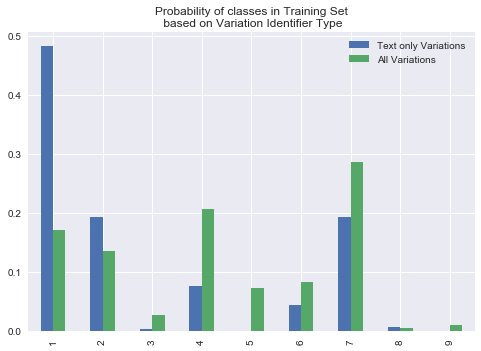

In [281]:
import seaborn
df = pd.DataFrame(list(zip(get_probs(text_classes), get_probs(train_variants['Class']))), columns=['Text only Variations', 'All Variations',])
#df.apply(pd.value_counts).plot.bar()
ax = df.plot.bar()
ax.set_xticklabels(range(1,10))
ax.set_title("Probability of classes in Training Set\n based on Variation Identifier Type")

### Missing Values

In the training set, there are a few entries that have null values in the text field to take note of. 

In [21]:
train.loc[train['Text'].str.len() < 100]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,null
1277,1277,ARID5B,Truncating Mutations,1,null
1407,1407,FGFR3,K508M,6,null
1639,1639,FLT1,Amplification,6,null
2755,2755,BRAF,G596C,7,null


Taking a closer clook at each gene that has a missing text field, we see that three of the five genes don't contain any other examples in the training set. This would likely result in a prediction value of the observed class at all instances of inference since we have no other observations to compare to. The most obvious way to deal with this will be to collect external data to inform the model, which we will look at later.

#### Genes with no text and only one observation in the dataset

##### ARID5B

In [23]:
train.loc[train['Gene'] == 'ARID5B']

,ID,Gene,Variation,Class,Text
1277,1277,ARID5B,Truncating Mutations,1,null


##### FLT1

In [25]:
train.loc[train['Gene'] == 'FLT1']

,ID,Gene,Variation,Class,Text
1639,1639,FLT1,Amplification,6,null


##### K508M

In [36]:
train.loc[train['Variation'] == 'K508M']

,ID,Gene,Variation,Class,Text
1407,1407,FGFR3,K508M,6,null


In [22]:
train.loc[train['Gene'] == 'FANCA']

,ID,Gene,Variation,Class,Text
1108,1108,FANCA,S858R,4,Fanconi anemia (FA) is an autosomal recessive ...
1109,1109,FANCA,S1088F,1,null
1110,1110,FANCA,Truncating Mutations,1,Abstract Fanconi anemia is characterized by c...
1111,1111,FANCA,H492R,4,Abstract Fanconi anemia (FA) is a genomic ins...
1112,1112,FANCA,Y510C,4,Abstract Fanconi anemia (FA) is a genomic ins...
1113,1113,FANCA,Deletion,1,Fanconi anemia (FA) is a genetic disease chara...
1114,1114,FANCA,L274P,4,Abstract Fanconi anemia (FA) is a genomic ins...
1115,1115,FANCA,W183A,4,Fanconi anemia (FA) is a recessively inherited...
1116,1116,FANCA,L210R,4,Abstract Fanconi anemia (FA) is a genomic ins...


In [35]:
len(train.loc[train['Gene'] == 'FGFR3'])

39

In [33]:
train.loc[train['Variation'] == 'G596C']

,ID,Gene,Variation,Class,Text
2755,2755,BRAF,G596C,7,null


In [34]:
len(train.loc[train['Gene'] == 'BRAF'])

93

Out of curiosity, let's see if there any of these matching combinations in the test set. Since the test set has fascimile data generated by an algorithm, we wouldn't want to use these examples for training, but it might be educational to see what the data looks like.

,ID,Gene,Variation,Class,Text


In [68]:
train_null_text = train[train['Text'].str.len() < 100].index.tolist()
null_text_variations = [train['Variation'][i] for i in train_null_text]
null_text_genes = [train['Gene'][i] for i in train_null_text]

In [ ]:
# Variation Matches only
# X_test[X_test.Variation.isin(null_text_variations)]
# Gene Matches only
#X_test[X_test.Gene.isin(null_text_genes)]

Turns out there are no matching pairs of genes and variants in the test set that correspond to the null `Text` values we found in training. 

In [72]:
len(X_test[X_test.Variation.isin(null_text_variations) & X_test.Gene.isin(null_text_genes)])

0

If we search for matches using the "`or`" condition we see that there are quite a few results. The missing text may have an impact during inference considering the limited dataset we have. 

Also important to notice is that there are null text values in the test set as well (i.e. at index `1623`). 

In [70]:
X_test[X_test.Variation.isin(null_text_variations) | X_test.Gene.isin(null_text_genes)].sort_values(['Gene', 'Variation'], ascending=[1,1])

,ID,Gene,Variation,Text
5102,5102,AKT1,Amplification,Glioblastomas frequently carry mutations in th...
2244,2244,APC,Truncating Mutations,Introduction Mutations in the adenomatous pol...
4856,4856,ASXL1,Truncating Mutations,The myelodysplastic syndromes (MDSs) are a het...
1623,1623,AURKB,Amplification,null
4609,4609,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
3330,3330,BCOR,Truncating Mutations,BCOR is a component of a variant Polycomb grou...
545,545,BRAF,F595L,"Recently, mutations in the B-Raf gene have bee..."
4903,4903,BRAF,G469L,Appropriate cancer care requires a thorough un...
1800,1800,BRAF,G469R,The BRAF gene encodes for a serine/threonine p...
4450,4450,BRAF,L505H,Significance Improving the treatment with BRA...


In [73]:
X_test.loc[X_test['Text'].str.len() < 100]

,ID,Gene,Variation,Text
1623,1623,AURKB,Amplification,null


We can see that this gene in the training set only has one observation with a different pairing of gene/variation than in the test set. Without knowing how to interpret the `Variation` value as a knowledgeable human interpreter might do, our model has limited predictive power.

One hypothesis to try could be to use the `Text` feature to find an embedded mapping to the `Variation` values in the data set. If this mapping contains information about the relationship between the `Text` features and the `Variation` values, it might help us make inferences in cases where we have missing values. 

In [76]:
train.loc[train['Gene'] == 'AURKB']

,ID,Gene,Variation,Class,Text
612,612,AURKB,Overexpression,2,Cancers arise owing to mutations in a subset o...


#### Usually short text entries

In addition to missing values, the training set contains a few unusually short text observations, including one in particular that is only `337` characters in length (`ID`: `1613`). We will need to be careful when interpreting these features, as they contain very little information relative to some of the other observations.

In [88]:
train.loc[(train.Text.str.len() > 100) & ( train.Text.str.len() < 1000)]

,ID,Gene,Variation,Class,Text
648,648,CDKN2A,Q50*,4,"The p16 gene is located in chromosome 9p21, a ..."
941,941,PDGFRB,ATF7IP-PDGFRB Fusion,2,Chronic myelomonocytic leukemia (CMML) is a my...
1583,1583,PMS1,Q233*,4,HEREDITARY nonpolyposis colorectal cancer (HNP...
1613,1613,VHL,L158Q,4,The case of a 40-year-old woman with severe ed...


In [91]:
len(train.loc[1613]['Text'])

337

In [92]:
train.loc[1613]['Text']

'The case of a 40-year-old woman with severe edema of the face and neck after the injection of a local dental anesthetic is presented. The reaction is attributed to the presence of sodium metabisulfite, and antioxidant, in the local anesthetic. Both the anesthetic and the sodium metabisulfite gave a delayed positive patch-test response.'

### `Text` data format and transformation

The `Text` column in the training set is an unformatted string of concatenated research papers with no titles or supplementary materials. There is also no indication of where one paper begins, and another ends. Manual inspection of the first entry, for example, reveals that the entry consists of the following articles:

- Guen VJ, Gamble C, Flajolet M, et al. [CDK10/cyclin M is a protein kinase that controls ETS2 degradation and is deficient in STAR syndrome](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3845122/). Proceedings of the National Academy of Sciences of the United States of America. 2013;110(48):19525-19530. doi:10.1073/pnas.1306814110.
- Unger, S; Böhm, D; Kaiser, F J; Kaulfuss, S; Borozdin, W; Buiting, K; Burfeind, P; Böhm, J; Barrionuevo, F; Craig, A; Borowski, K; Keppler-Noreuil, K; Schmitt-Mechelke, T; Steiner, B; Bartholdi, D; Lemke, J; Mortier, G; Sandford, R; Zabel, B; Superti-Furga, A; Kohlhase, J (2008). [Mutations in the cyclin family member FAM58A cause an X-linked dominant disorder characterized by syndactyly, telecanthus and anogenital and renal malformations](http://www.humangenetik-freiburg.de/mediapool/43/433039/data/FAM58ANatGenet2008.pdf). Nature Genetics, 40(3):287-289.

##### Article 1 (Guen VJ, et al.) 

In [96]:
 train['Text'][0][:1000]

'Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

##### Article 2: (Unger, S, et al.)

In [98]:
paper_two_start = re.search("We identified four unrelated girls", train['Text'][0]).start()
print(train['Text'][0][paper_two_start:paper_two_start+1000])

We identified four unrelated girls with anogenital and renal malformations, dysmorphic facial features, normal intellect and syndactyly of toes. A similar combination of features had been reported previously in a mother–daughter pair1 (Table 1 and Supplementary Note online). These authors noted clinical overlap with Townes-Brocks syndrome but suggested that the phenotype represented a separate autosomal dominant entity (MIM601446). Here we define the cardinal features of this syndrome as a characteristic facial appearance with apparent telecanthus and broad tripartite nasal tip, variable syndactyly of toes 2–5, hypoplastic labia, anal atresia and urogenital malformations (Fig. 1a–h). We also observed a variety of other features (Table 1).  Figure 1: Clinical and molecular characterization of STAR syndrome.  Figure 1 : Clinical and molecular characterization of STAR syndrome. (a–f) Facial appearances of cases 1–3 (apparent telecanthus, dysplastic ears and thin upper lips; a,c,e), and to

#### Variation of `Text` Observations

Another thing to notice is that the text corpuses are not unique to gene/variation pairings. The gene `RUNX1` has variants of `Y113*`, `P173S`, `S70fsX93`, and `A122*` in the sample, but all have the same text corpus. Two others contain some of the same text, but with a slight variation.

It seems like a good strategy would take these slight variations into account when applying a transformation to the text and tokenizing the corpus.

In [99]:
train.loc[train['Gene'] == 'RUNX1']

,ID,Gene,Variation,Class,Text
3297,3297,RUNX1,R177*,4,THE AML1 GENE IS KNOWN as the most frequent ta...
3298,3298,RUNX1,Y113*,4,Introduction Myelodysplastic syndromes (MDS) ...
3299,3299,RUNX1,R139G,4,The BCR-ABL fusion protein generated by t(9;22...
3300,3300,RUNX1,K83N,4,The most frequent mutations associated with le...
3301,3301,RUNX1,R177Q,4,The most frequent mutations associated with le...
3302,3302,RUNX1,R166Q,4,Familial platelet disorder with predisposition...
3303,3303,RUNX1,P173S,4,Introduction Myelodysplastic syndromes (MDS) ...
3304,3304,RUNX1,R201Q,4,Familial platelet disorder with predisposition...
3305,3305,RUNX1,S70fsX93,4,Introduction Myelodysplastic syndromes (MDS) ...
3306,3306,RUNX1,W279*,1,Here we report two new RUNX1 mutations in one ...


In [103]:
t_starts_with = pd.Series(train['Text'])
RUNX1_subset_1 = pd.DataFrame(t_starts_with.loc[t_starts_with.str.startswith("Introduction  Myelodysplastic", na=False)])
RUNX1_subset_1['text_length'] = RUNX1_subset_1.apply(lambda t: len(t['Text']), axis=1)
RUNX1_subset_1['Gene'] = RUNX1_subset_1.apply(lambda t: train['Gene'][t.name], axis=1)
RUNX1_subset_1['Variation'] = RUNX1_subset_1.apply(lambda t: train['Variation'][t.name], axis=1)
RUNX1_subset_1.sort_values(['text_length'])

,Text,text_length,Gene,Variation
3298,Introduction Myelodysplastic syndromes (MDS) ...,40127,RUNX1,Y113*
3303,Introduction Myelodysplastic syndromes (MDS) ...,40127,RUNX1,P173S
3305,Introduction Myelodysplastic syndromes (MDS) ...,40127,RUNX1,S70fsX93
3317,Introduction Myelodysplastic syndromes (MDS) ...,40127,RUNX1,A122*
3316,Introduction Myelodysplastic syndromes (MDS) ...,73895,RUNX1,D171N
3314,Introduction Myelodysplastic syndromes (MDS) ...,94151,RUNX1,G42R


### External Data Discussion

- Note: Further investigation shows that the text references for each gene can be found at http://oncokb.org/. For example:
    - FAM58A: http://oncokb.org/#/gene/FAM58A
    - RUNX1: http://oncokb.org/#/gene/RUNX1

- Note also: Using labels from this database allows for near perfect accuracy, but is forbidden due to contest rules

- See thread at: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/36182 for more info